In [ ]:
"Dataset Generator using the checkpoints"

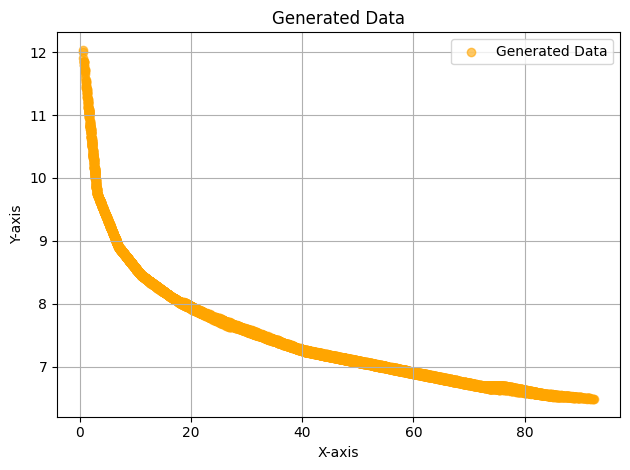

In [28]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Define the Generator class
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(2, 16),  # Input size is 2 (latent space)
            nn.LeakyReLU(0.2),
            nn.Linear(16, 16),
            nn.LeakyReLU(0.2),
            nn.Linear(16, 2)  # Output size should be 2 for 2D data
        )

    def forward(self, input):
        return self.main(input)

# Function to sample noise
def sample_Z(m, n):
    return torch.Tensor(np.random.uniform(-1., 1., size=[m, n]))

# Function to generate new data
def generate_data(generator, num_samples, noise_dim, device):
    generator.to(device)  # Ensure the model is on the correct device
    generator.eval()  # Ensure the model is in evaluation mode
    with torch.no_grad():
        noise = sample_Z(num_samples, noise_dim).to(device)  # Sample noise and move to the same device as the model
        generated_data = generator(noise)
    return generated_data.cpu().numpy()

# Load the trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = Generator()

# Load the checkpoint
checkpoint_path = '../plots/checkpoint/checkpoint_65000.tar'  # Adjust this path if needed
checkpoint = torch.load(checkpoint_path, map_location=device)
generator.load_state_dict(checkpoint['generator_state_dict'])

# Specify how many samples you want and the noise dimension
num_samples = 10000  # Number of samples you want to generate
noise_dim = 2       # Dimension of the latent space

# Generate new data using the loaded generator
new_data = generate_data(generator, num_samples, noise_dim, device)

# Save the generated data to a file
np.savetxt('generated_data.txt', new_data)

# Optionally, plot some of the generated data
plt.figure()
plt.scatter(new_data[:, 0], new_data[:, 1], color='orange', label='Generated Data', alpha=0.6)
plt.title('Generated Data')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('generated_data_plot.png', dpi=300)
plt.show()


In [1]:
"Data Mapper for a perticular enrichment point"

'Data Mapper for a perticular enrichment point'

Using device: cuda
Input Enrichment: 30.52%
Generated Flux Samples (neutrons/cm²/s, 20 matches):
Sample 1: 7.560715198516846
Sample 2: 7.562943458557129
Sample 3: 7.570269584655762
Sample 4: 7.573394298553467
Sample 5: 7.560070514678955
Sample 6: 7.5577192306518555
Sample 7: 7.574565887451172
Sample 8: 7.570842266082764
Sample 9: 7.542948246002197
Sample 10: 7.552548408508301
Average Generated Flux: 7.563451290130615 neutrons/cm²/s


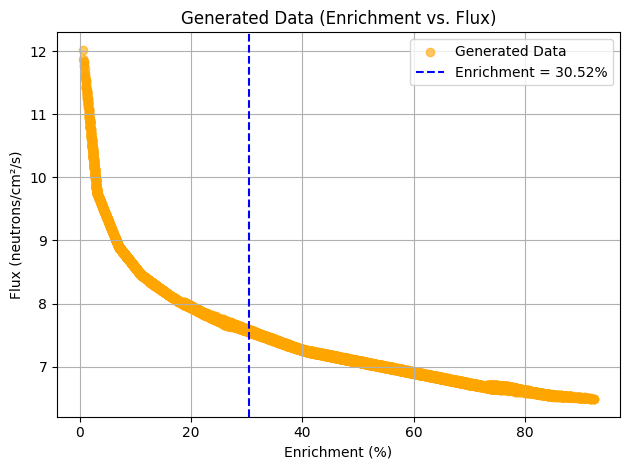

In [35]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Define the Generator class (matches the training architecture)
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(2, 16),  # Input size is 2 (latent space)
            nn.LeakyReLU(0.2),
            nn.Linear(16, 16),
            nn.LeakyReLU(0.2),
            nn.Linear(16, 2)  # Output size is 2 (enrichment, flux)
        )

    def forward(self, input):
        return self.main(input)

# Function to sample noise
def sample_Z(m, n):
    return torch.Tensor(np.random.uniform(-1., 1., size=[m, n]))

# Function to generate new data
def generate_data(generator, num_samples, noise_dim, device):
    generator.to(device)  # Ensure the model is on the correct device
    generator.eval()  # Ensure the model is in evaluation mode
    with torch.no_grad():
        noise = sample_Z(num_samples, noise_dim).to(device)  # Sample noise and move to device
        generated_data = generator(noise)
    return generated_data.cpu().numpy()

# Load the trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
generator = Generator()

# Load the checkpoint
checkpoint_path = "../plots/checkpoint/checkpoint_65000.tar"  # Updated to 3000 iterations
checkpoint = torch.load(checkpoint_path, map_location=device)
generator.load_state_dict(checkpoint['generator_state_dict'])
generator.to(device)

# Specify parameters
num_samples = 10000  # Generate more samples to increase chances of finding a match
noise_dim = 2        # Dimension of the latent space
enrichment_value = 30.52  # Desired enrichment value (e.g., 3.5%)
tolerance = 0.1      # Tolerance for matching enrichment

# Generate new data using the loaded generator
new_data = generate_data(generator, num_samples, noise_dim, device)

# Split the generated data into enrichment and flux
generated_enrichment = new_data[:, 0]  # First column: enrichment
generated_flux = new_data[:, 1]        # Second column: flux

# Filter for samples where the generated enrichment matches the input within tolerance
mask = (generated_enrichment >= enrichment_value - tolerance) & (generated_enrichment <= enrichment_value + tolerance)
matching_flux = generated_flux[mask]

# Output the results
if len(matching_flux) > 0:
    avg_flux = np.mean(matching_flux)
    print(f"Input Enrichment: {enrichment_value}%")
    print(f"Generated Flux Samples (neutrons/cm²/s, {len(matching_flux)} matches):")
    for i, flux in enumerate(matching_flux[:10]):  # Print up to 10 samples
        print(f"Sample {i+1}: {flux}")
    print(f"Average Generated Flux: {avg_flux} neutrons/cm²/s")
else:
    print(f"No generated samples matched the enrichment value {enrichment_value}% within tolerance {tolerance}.")

# Optionally, plot the generated data
plt.figure()
plt.scatter(new_data[:, 0], new_data[:, 1], color='orange', label='Generated Data', alpha=0.6)
plt.axvline(x=enrichment_value, color='blue', linestyle='--', label=f'Enrichment = {enrichment_value}%')
plt.title('Generated Data (Enrichment vs. Flux)')
plt.xlabel('Enrichment (%)')
plt.ylabel('Flux (neutrons/cm²/s)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('generated_data_plot_3000.png', dpi=300)
plt.show()

In [2]:
"COMPARISON DATASET GENERATOR"

'COMPARISON DATASET GENERATOR'

Using device: cuda

Saved average flux values for 100 enrichments to 'enrichment_flux.csv'.


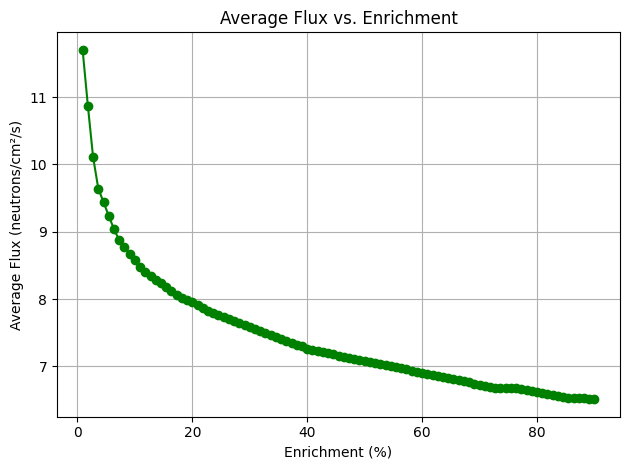

In [37]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import csv

# Define the Generator class
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(2, 16),
            nn.LeakyReLU(0.2),
            nn.Linear(16, 16),
            nn.LeakyReLU(0.2),
            nn.Linear(16, 2)
        )

    def forward(self, input):
        return self.main(input)

# Function to sample noise
def sample_Z(m, n):
    return torch.Tensor(np.random.uniform(-1., 1., size=[m, n]))

# Function to generate new data
def generate_data(generator, num_samples, noise_dim, device):
    generator.to(device)
    generator.eval()
    with torch.no_grad():
        noise = sample_Z(num_samples, noise_dim).to(device)
        generated_data = generator(noise)
    return generated_data.cpu().numpy()

# Load the trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
generator = Generator()
checkpoint_path = "../plots/checkpoint/checkpoint_65000.tar"
checkpoint = torch.load(checkpoint_path, map_location=device)
generator.load_state_dict(checkpoint['generator_state_dict'])
generator.to(device)

# Parameters
num_samples = 10000
noise_dim = 2
tolerance = 0.1

# Generate base data
new_data = generate_data(generator, num_samples, noise_dim, device)
generated_enrichment = new_data[:, 0]
generated_flux = new_data[:, 1]

# Generate enrichment list
enrichment_list = np.linspace(0, 90, 100).tolist()

# Store results
results = []

# Match enrichments
for enrichment_value in enrichment_list:
    mask = (generated_enrichment >= enrichment_value - tolerance) & (generated_enrichment <= enrichment_value + tolerance)
    matching_flux = generated_flux[mask]
    if len(matching_flux) > 0:
        avg_flux = np.mean(matching_flux)
    else:
        avg_flux = None  # Could be np.nan if preferred
    results.append((enrichment_value, avg_flux))

# Save to CSV
csv_filename = 'enrichment_flux.csv'
with open(csv_filename, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Enrichment (%)', 'Average Flux (neutrons/cm²/s)'])
    for enrichment, flux in results:
        writer.writerow([enrichment, flux])

print(f"\nSaved average flux values for 100 enrichments to '{csv_filename}'.")

# Optional: Plotting enrichment vs average flux
valid_results = [(e, f) for e, f in results if f is not None]
if valid_results:
    enrichments_plot, fluxes_plot = zip(*valid_results)
    plt.figure()
    plt.plot(enrichments_plot, fluxes_plot, marker='o', linestyle='-', color='green')
    plt.title('Average Flux vs. Enrichment')
    plt.xlabel('Enrichment (%)')
    plt.ylabel('Average Flux (neutrons/cm²/s)')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('enrichment_vs_flux.png', dpi=300)
    plt.show()


In [44]:
"Loop based"

'Loop based'

Using device: cuda

Saved average flux values for 100 enrichments to 'enrichment_flux.csv'.


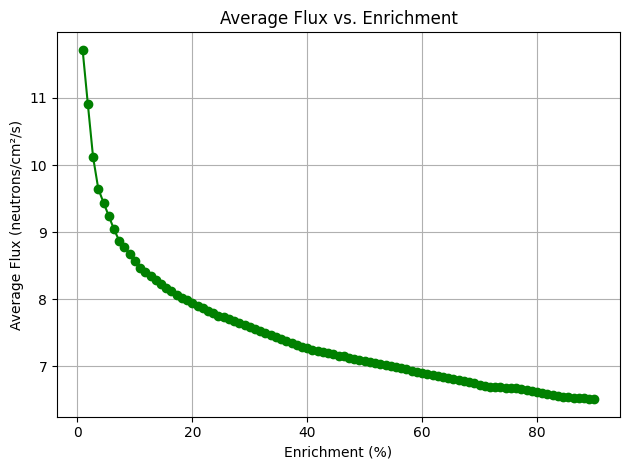

In [43]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import csv

# Define the Generator class
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(2, 16),
            nn.LeakyReLU(0.2),
            nn.Linear(16, 16),
            nn.LeakyReLU(0.2),
            nn.Linear(16, 2)
        )

    def forward(self, input):
        return self.main(input)

# Function to sample noise
def sample_Z(m, n):
    return torch.Tensor(np.random.uniform(-1., 1., size=[m, n]))

# Function to generate new data
def generate_data(generator, num_samples, noise_dim, device):
    generator.to(device)
    generator.eval()
    with torch.no_grad():
        noise = sample_Z(num_samples, noise_dim).to(device)
        generated_data = generator(noise)
    return generated_data.cpu().numpy()

# Load the trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
generator = Generator()
checkpoint_path = "../plots/checkpoint/checkpoint_65000.tar"
checkpoint = torch.load(checkpoint_path, map_location=device)
generator.load_state_dict(checkpoint['generator_state_dict'])
generator.to(device)

# Parameters
num_samples = 10000
noise_dim = 2
tolerance = 0.1

# Generate base data
new_data = generate_data(generator, num_samples, noise_dim, device)
generated_enrichment = new_data[:, 0]
generated_flux = new_data[:, 1]

# Explicit list of 100 enrichment values from 0 to 90
enrichment_percent = [ 5.31, 5.62, 5.94, 6.25, 6.56, 6.87, 7.19, 7.5, 7.81, 8.12,
    8.44, 8.75, 9.06, 9.37, 9.69, 10, 10.31, 10.62, 10.94, 11.25,
    11.56, 11.87, 12.19, 12.5, 12.81, 13.12, 13.44, 13.75, 14.06, 14.37,
    14.69, 15, 15.31, 15.62, 15.94, 16.25, 16.56, 16.87, 17.19, 17.5,
    17.81, 18.12, 18.44, 18.75, 19.06, 19.37, 19.69, 20, 20.31, 20.62,
    20.94, 21.25, 21.56, 21.87, 22.19, 22.5, 22.81, 23.12, 23.44, 23.75,
    24.06, 24.37, 24.69, 25, 25.31, 25.62, 25.94, 26.25, 26.56, 26.87,
    27.19, 27.5, 27.81, 28.12, 28.44, 28.75, 29.06, 29.37, 29.69, 30,
    30.31, 30.62, 30.94, 31.25, 31.56, 31.87, 32.19, 32.5, 32.81, 33.12,
    33.44, 33.75, 34.06, 34.37, 34.69, 35, 35.31, 35.62, 35.94, 36.25 ]


# Store results
results = []

# Match enrichments
for enrichment_value in enrichment_list:
    mask = (generated_enrichment >= enrichment_value - tolerance) & (generated_enrichment <= enrichment_value + tolerance)
    matching_flux = generated_flux[mask]
    if len(matching_flux) > 0:
        avg_flux = np.mean(matching_flux)
    else:
        avg_flux = None  # or np.nan if preferred
    results.append((enrichment_value, avg_flux))

# Save to CSV
csv_filename = 'enrichment_flux.csv'
with open(csv_filename, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Enrichment (%)', 'Average Flux (neutrons/cm²/s)'])
    for enrichment, flux in results:
        writer.writerow([enrichment, flux])

print(f"\nSaved average flux values for 100 enrichments to '{csv_filename}'.")

# Optional: Plotting enrichment vs average flux
valid_results = [(e, f) for e, f in results if f is not None]
if valid_results:
    enrichments_plot, fluxes_plot = zip(*valid_results)
    plt.figure()
    plt.plot(enrichments_plot, fluxes_plot, marker='o', linestyle='-', color='green')
    plt.title('Average Flux vs. Enrichment')
    plt.xlabel('Enrichment (%)')
    plt.ylabel('Average Flux (neutrons/cm²/s)')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('enrichment_vs_flux.png', dpi=300)
    plt.show()


In [45]:
"List based"

'List based'

Using device: cuda

✅ Saved average flux values for 100 enrichments to 'enrichment_flux.csv'.


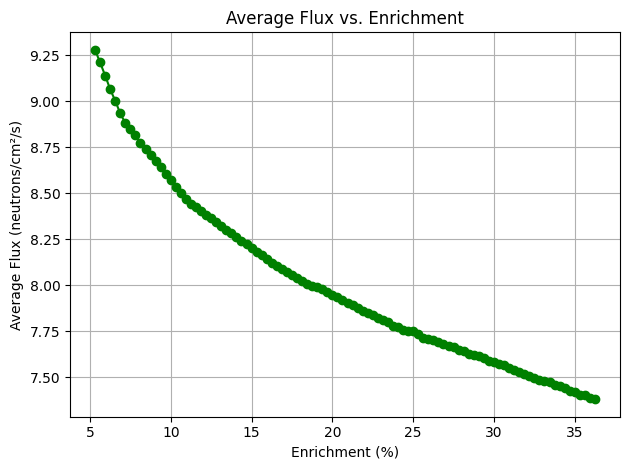

In [46]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import csv

# Define the Generator class
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(2, 16),
            nn.LeakyReLU(0.2),
            nn.Linear(16, 16),
            nn.LeakyReLU(0.2),
            nn.Linear(16, 2)
        )

    def forward(self, input):
        return self.main(input)

# Function to sample noise
def sample_Z(m, n):
    return torch.Tensor(np.random.uniform(-1., 1., size=[m, n]))

# Function to generate new data
def generate_data(generator, num_samples, noise_dim, device):
    generator.to(device)
    generator.eval()
    with torch.no_grad():
        noise = sample_Z(num_samples, noise_dim).to(device)
        generated_data = generator(noise)
    return generated_data.cpu().numpy()

# Load the trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
generator = Generator()
checkpoint_path = "../plots/checkpoint/checkpoint_65000.tar"
checkpoint = torch.load(checkpoint_path, map_location=device)
generator.load_state_dict(checkpoint['generator_state_dict'])
generator.to(device)

# Parameters
num_samples = 10000
noise_dim = 2
tolerance = 0.1

# Generate base data
new_data = generate_data(generator, num_samples, noise_dim, device)
generated_enrichment = new_data[:, 0]
generated_flux = new_data[:, 1]

# ✅ Use your explicit enrichment levels
enrichment_percent = [
    5.31, 5.62, 5.94, 6.25, 6.56, 6.87, 7.19, 7.5, 7.81, 8.12,
    8.44, 8.75, 9.06, 9.37, 9.69, 10, 10.31, 10.62, 10.94, 11.25,
    11.56, 11.87, 12.19, 12.5, 12.81, 13.12, 13.44, 13.75, 14.06, 14.37,
    14.69, 15, 15.31, 15.62, 15.94, 16.25, 16.56, 16.87, 17.19, 17.5,
    17.81, 18.12, 18.44, 18.75, 19.06, 19.37, 19.69, 20, 20.31, 20.62,
    20.94, 21.25, 21.56, 21.87, 22.19, 22.5, 22.81, 23.12, 23.44, 23.75,
    24.06, 24.37, 24.69, 25, 25.31, 25.62, 25.94, 26.25, 26.56, 26.87,
    27.19, 27.5, 27.81, 28.12, 28.44, 28.75, 29.06, 29.37, 29.69, 30,
    30.31, 30.62, 30.94, 31.25, 31.56, 31.87, 32.19, 32.5, 32.81, 33.12,
    33.44, 33.75, 34.06, 34.37, 34.69, 35, 35.31, 35.62, 35.94, 36.25
]

# Store results
results = []

# ✅ Corrected loop using enrichment_percent instead of enrichment_list
for enrichment_value in enrichment_percent:
    mask = (generated_enrichment >= enrichment_value - tolerance) & (generated_enrichment <= enrichment_value + tolerance)
    matching_flux = generated_flux[mask]
    if len(matching_flux) > 0:
        avg_flux = np.mean(matching_flux)
    else:
        avg_flux = None
    results.append((enrichment_value, avg_flux))

# Save to CSV
csv_filename = 'enrichment_flux.csv'
with open(csv_filename, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Enrichment (%)', 'Average Flux (neutrons/cm²/s)'])
    for enrichment, flux in results:
        writer.writerow([enrichment, flux])

print(f"\n✅ Saved average flux values for 100 enrichments to '{csv_filename}'.")

# Optional: Plotting enrichment vs average flux
valid_results = [(e, f) for e, f in results if f is not None]
if valid_results:
    enrichments_plot, fluxes_plot = zip(*valid_results)
    plt.figure()
    plt.plot(enrichments_plot, fluxes_plot, marker='o', linestyle='-', color='green')
    plt.title('Average Flux vs. Enrichment')
    plt.xlabel('Enrichment (%)')
    plt.ylabel('Average Flux (neutrons/cm²/s)')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('enrichment_vs_flux.png', dpi=300)
    plt.show()
